# **Experiment 1 Bitcoin (Delete)**

1/1 [==============================] - 1s 1s/step
RMSE: 6976.95
MAE: 5925.24
Genauigkeit (Steigung/Senkung): 62.07%
Vorhersagen und tatsächliche Preise wurden in 'btc_predictions.csv' gespeichert.
Buy am 2022-01-22 für 37978.59 (Vorhergesagt) und Sell am 2022-01-26 für 50269.09 mit Profit von 1821.87


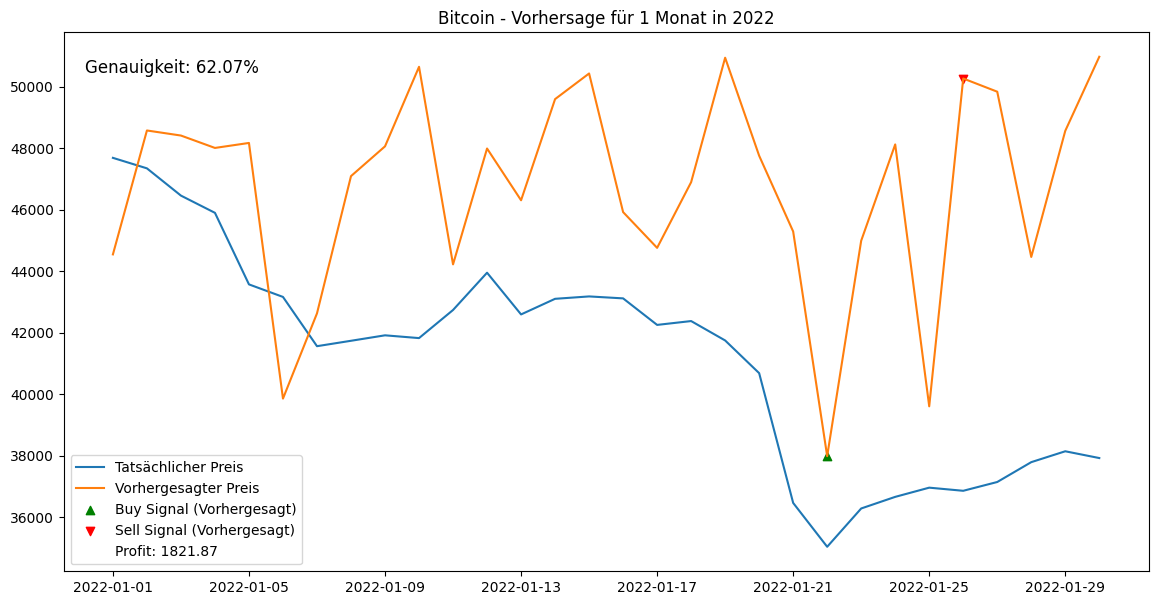

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import ta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import argrelextrema


# Datenabruf
def fetch_test_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date, progress=False)
    data.reset_index(inplace=True)
    return data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]


# Technische Indikatoren hinzufügen
def add_technical_indicators(df):
    df['rsi'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
    macd = ta.trend.MACD(close=df['Close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    bollinger = ta.volatility.BollingerBands(close=df['Close'])
    df['bb_mavg'] = bollinger.bollinger_mavg()
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    stochastic = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['stoch'] = stochastic.stoch()
    df['stoch_signal'] = stochastic.stoch_signal()
    df.fillna(0, inplace=True)
    return df


# Fehlende Spalten ergänzen
def add_missing_columns(df, required_columns):
    for col in required_columns:
        if col not in df.columns:
            df[col] = 0
    df = df[required_columns]
    return df


# Inverse Transformation der Vorhersagen
def inverse_transform(predictions, scaler, feature_columns):
    dummy = np.zeros((len(predictions), len(feature_columns)))
    close_index = feature_columns.index('Close')
    predictions = predictions.reshape(-1, 1)
    dummy[:, close_index] = predictions.flatten()
    inverted = scaler.inverse_transform(dummy)
    return inverted[:, close_index]


# Berechnung der Genauigkeit (Accuracy)
def calculate_accuracy(actual_prices, predicted_prices):
    correct_trend = 0
    total_predictions = len(actual_prices) - 1
    for i in range(1, len(actual_prices)):
        actual_trend = actual_prices[i] - actual_prices[i - 1]
        predicted_trend = predicted_prices[i] - predicted_prices[i - 1]
        if (actual_trend >= 0 and predicted_trend >= 0) or (actual_trend < 0 and predicted_trend < 0):
            correct_trend += 1
    accuracy = correct_trend / total_predictions
    return accuracy


# Buy- und Sell-Signale basierend auf den vorhergesagten Preisen
def find_best_single_trade(predicted_prices, actual_prices, date_values):
    buy_signals = argrelextrema(predicted_prices, np.less)[0]
    sell_signals = argrelextrema(predicted_prices, np.greater)[0]

    best_buy = None
    best_sell = None
    best_profit = -np.inf

    # Suche das beste Buy-Signal und das beste Sell-Signal basierend auf dem Profit
    for buy in buy_signals:
        for sell in sell_signals:
            if sell > buy:  # Sell muss nach Buy kommen
                profit = actual_prices[sell] - actual_prices[buy]  # Berechnung des Profits auf Grundlage der tatsächlichen Preise
                if profit > best_profit:
                    best_buy = buy
                    best_sell = sell
                    best_profit = profit

    return best_buy, best_sell, best_profit

# Modell evaluieren ohne rekursive Vorhersagen und mit Buy/Sell basierend auf den Vorhersagen
def evaluate_model(model_info, data, actual_data_2022, asset_name, prediction_steps=30):
    model = load_model(model_info["model_path"])
    with open(model_info["scaler_path"], 'rb') as f:
        scaler = pickle.load(f)
    feature_columns = model_info["feature_columns"]

    actual_dates_2022 = actual_data_2022['Date'].values
    actual_prices_2022 = actual_data_2022['Close'].values

    # Verwende nur Daten bis zum 31.12.2021 für die Vorhersage
    prediction_start_idx = len(data) - prediction_steps
    data = add_missing_columns(data, feature_columns)
    data = data[feature_columns]
    data_scaled = scaler.transform(data)

    # Nimm die letzten Daten als Eingabesequenz für das Modell (nur bis 2021)
    input_sequence = data_scaled[prediction_start_idx - 50:prediction_start_idx]

    # Vorhersage für 30 Schritte (1 Monat) basierend auf den Daten bis 2021
    predictions = model.predict(input_sequence[np.newaxis, :, :])
    predictions_inv = inverse_transform(predictions.flatten(), scaler, feature_columns)

    # Vergleiche die Vorhersagen mit den tatsächlichen Daten aus 2022
    prediction_steps = min(len(actual_dates_2022), len(predictions_inv), prediction_steps)

    # Berechnung der Genauigkeit mit RMSE und MAE
    rmse = np.sqrt(mean_squared_error(actual_prices_2022[:prediction_steps], predictions_inv[:prediction_steps]))
    mae = mean_absolute_error(actual_prices_2022[:prediction_steps], predictions_inv[:prediction_steps])
    accuracy = calculate_accuracy(actual_prices_2022[:prediction_steps], predictions_inv[:prediction_steps])

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Genauigkeit (Steigung/Senkung): {accuracy:.2%}")

    # Buy- und Sell-Signale basierend auf den Vorhersagen finden und tatsächlichen Profit berechnen
    buy_signal, sell_signal, profit = find_best_single_trade(predictions_inv[:prediction_steps],
                                                             actual_prices_2022[:prediction_steps],
                                                             actual_dates_2022[:prediction_steps])

    # Ausgabe der Vorhersagen und tatsächlichen Preise in eine CSV-Datei
    prediction_df = pd.DataFrame({
        'Datum': actual_dates_2022[:prediction_steps],
        'Tatsächlicher Preis': actual_prices_2022[:prediction_steps],
        'Vorhergesagter Preis': predictions_inv[:prediction_steps]
    })
    prediction_df.to_csv('btc_predictions.csv', index=False)
    print("Vorhersagen und tatsächliche Preise wurden in 'btc_predictions.csv' gespeichert.")

    # Plotten der Vorhersagen und tatsächlichen Preise
    plt.figure(figsize=(14, 7))
    plt.plot(actual_dates_2022[:prediction_steps], actual_prices_2022[:prediction_steps], label='Tatsächlicher Preis')
    plt.plot(actual_dates_2022[:prediction_steps], predictions_inv[:prediction_steps], label='Vorhergesagter Preis')

    # Buy- und Sell-Signale anzeigen
    if buy_signal is not None and sell_signal is not None:
        # Buy- und Sell-Signale basierend auf den vorhergesagten Preisen
        plt.scatter(actual_dates_2022[buy_signal], predictions_inv[buy_signal], marker='^', color='g',
                    label='Buy Signal (Vorhergesagt)')
        plt.scatter(actual_dates_2022[sell_signal], predictions_inv[sell_signal], marker='v', color='r',
                    label='Sell Signal (Vorhergesagt)')

        # Printen von Buy- und Sell-Daten
        print(
            f"Buy am {pd.to_datetime(actual_dates_2022[buy_signal]).date()} für {predictions_inv[buy_signal]:.2f} (Vorhergesagt) und Sell am {pd.to_datetime(actual_dates_2022[sell_signal]).date()} für {predictions_inv[sell_signal]:.2f} mit Profit von {profit:.2f}")

        # Füge den Profit als zusätzlichen Eintrag zur Legende hinzu
        plt.plot([], [], ' ', label=f'Profit: {profit:.2f}')

    # Genauigkeit im Diagramm anzeigen
    plt.text(0.02, 0.95, f"Genauigkeit: {accuracy:.2%}", transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top')

    plt.title(f'{asset_name} - Vorhersage für 1 Monat in 2022')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    # Lade Daten bis Ende 2021
    btc_data = fetch_test_data('BTC-USD', '2010-01-01', '2021-12-31')
    btc_data_with_indicators = add_technical_indicators(btc_data.copy())

    # Lade nur die Daten für 2022 zur Evaluierung (nicht für Vorhersage)
    btc_data_2022 = fetch_test_data('BTC-USD', '2022-01-01', '2022-01-31')
    btc_data_2022 = add_technical_indicators(btc_data_2022)

    model_info = {
        "model_path": "../../models/standard_model/btc_standard_model.h5",
        "scaler_path": "../../models/scaler/btc_scaler_with_indicators.pkl",
        "feature_columns": ['Open', 'High', 'Low', 'Close', 'Volume', 'Fed_Rate', 'Inflation', 'rsi', 'macd',
                            'macd_signal', 'bb_mavg', 'bb_high', 'bb_low', 'stoch', 'stoch_signal']
    }

    evaluate_model(model_info, btc_data_with_indicators, btc_data_2022, "Bitcoin", prediction_steps=30)


# **Experiment 1 Ethereum (Delete)**

1/1 [==============================] - 1s 1s/step
RMSE: 616.23
MAE: 514.42
Genauigkeit (Steigung/Senkung): 58.62%
Vorhersagen und tatsächliche Preise wurden in 'eth_predictions.csv' gespeichert.
Buy am 2022-01-10 für 3035.77 (Vorhergesagt) und Sell am 2022-01-16 für 3864.76 mit Profit von 267.82


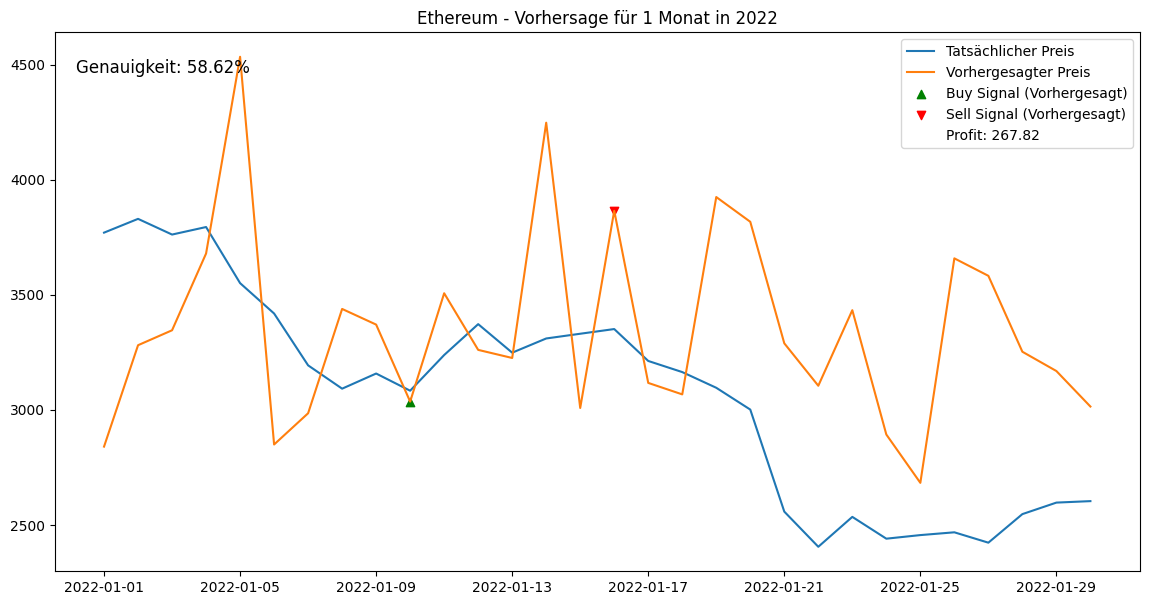

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import ta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import argrelextrema


# Datenabruf
def fetch_test_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date, progress=False)
    data.reset_index(inplace=True)
    return data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]


# Technische Indikatoren hinzufügen
def add_technical_indicators(df):
    df['rsi'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
    macd = ta.trend.MACD(close=df['Close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    bollinger = ta.volatility.BollingerBands(close=df['Close'])
    df['bb_mavg'] = bollinger.bollinger_mavg()
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    stochastic = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['stoch'] = stochastic.stoch()
    df['stoch_signal'] = stochastic.stoch_signal()
    df.fillna(0, inplace=True)
    return df


# Fehlende Spalten ergänzen
def add_missing_columns(df, required_columns):
    for col in required_columns:
        if col not in df.columns:
            df[col] = 0
    df = df[required_columns]
    return df


# Inverse Transformation der Vorhersagen
def inverse_transform(predictions, scaler, feature_columns):
    dummy = np.zeros((len(predictions), len(feature_columns)))
    close_index = feature_columns.index('Close')
    predictions = predictions.reshape(-1, 1)
    dummy[:, close_index] = predictions.flatten()
    inverted = scaler.inverse_transform(dummy)
    return inverted[:, close_index]


# Berechnung der Genauigkeit (Accuracy)
def calculate_accuracy(actual_prices, predicted_prices):
    correct_trend = 0
    total_predictions = len(actual_prices) - 1
    for i in range(1, len(actual_prices)):
        actual_trend = actual_prices[i] - actual_prices[i - 1]
        predicted_trend = predicted_prices[i] - predicted_prices[i - 1]
        if (actual_trend >= 0 and predicted_trend >= 0) or (actual_trend < 0 and predicted_trend < 0):
            correct_trend += 1
    accuracy = correct_trend / total_predictions
    return accuracy


# Buy- und Sell-Signale basierend auf den vorhergesagten Preisen
def find_best_single_trade(predicted_prices, actual_prices, date_values):
    buy_signals = argrelextrema(predicted_prices, np.less)[0]
    sell_signals = argrelextrema(predicted_prices, np.greater)[0]

    best_buy = None
    best_sell = None
    best_profit = -np.inf

    # Suche das beste Buy-Signal und das beste Sell-Signal basierend auf dem Profit
    for buy in buy_signals:
        for sell in sell_signals:
            if sell > buy:  # Sell muss nach Buy kommen
                profit = actual_prices[sell] - actual_prices[buy]  # Berechnung des Profits auf Grundlage der tatsächlichen Preise
                if profit > best_profit:
                    best_buy = buy
                    best_sell = sell
                    best_profit = profit

    return best_buy, best_sell, best_profit

# Modell evaluieren ohne rekursive Vorhersagen und mit Buy/Sell basierend auf den Vorhersagen
def evaluate_model(model_info, data, actual_data_2022, asset_name, prediction_steps=30):
    model = load_model(model_info["model_path"])
    with open(model_info["scaler_path"], 'rb') as f:
        scaler = pickle.load(f)
    feature_columns = model_info["feature_columns"]

    actual_dates_2022 = actual_data_2022['Date'].values
    actual_prices_2022 = actual_data_2022['Close'].values

    # Verwende nur Daten bis zum 31.12.2021 für die Vorhersage
    prediction_start_idx = len(data) - prediction_steps
    data = add_missing_columns(data, feature_columns)
    data = data[feature_columns]
    data_scaled = scaler.transform(data)

    # Nimm die letzten Daten als Eingabesequenz für das Modell (nur bis 2021)
    input_sequence = data_scaled[prediction_start_idx - 50:prediction_start_idx]

    # Vorhersage für 30 Schritte (1 Monat) basierend auf den Daten bis 2021
    predictions = model.predict(input_sequence[np.newaxis, :, :])
    predictions_inv = inverse_transform(predictions.flatten(), scaler, feature_columns)

    # Vergleiche die Vorhersagen mit den tatsächlichen Daten aus 2022
    prediction_steps = min(len(actual_dates_2022), len(predictions_inv), prediction_steps)

    # Berechnung der Genauigkeit mit RMSE und MAE
    rmse = np.sqrt(mean_squared_error(actual_prices_2022[:prediction_steps], predictions_inv[:prediction_steps]))
    mae = mean_absolute_error(actual_prices_2022[:prediction_steps], predictions_inv[:prediction_steps])
    accuracy = calculate_accuracy(actual_prices_2022[:prediction_steps], predictions_inv[:prediction_steps])

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Genauigkeit (Steigung/Senkung): {accuracy:.2%}")

    # Buy- und Sell-Signale basierend auf den Vorhersagen finden und tatsächlichen Profit berechnen
    buy_signal, sell_signal, profit = find_best_single_trade(predictions_inv[:prediction_steps],
                                                             actual_prices_2022[:prediction_steps],
                                                             actual_dates_2022[:prediction_steps])

    # Ausgabe der Vorhersagen und tatsächlichen Preise in eine CSV-Datei
    prediction_df = pd.DataFrame({
        'Datum': actual_dates_2022[:prediction_steps],
        'Tatsächlicher Preis': actual_prices_2022[:prediction_steps],
        'Vorhergesagter Preis': predictions_inv[:prediction_steps]
    })
    prediction_df.to_csv('eth_predictions.csv', index=False)
    print("Vorhersagen und tatsächliche Preise wurden in 'eth_predictions.csv' gespeichert.")

    # Plotten der Vorhersagen und tatsächlichen Preise
    plt.figure(figsize=(14, 7))
    plt.plot(actual_dates_2022[:prediction_steps], actual_prices_2022[:prediction_steps], label='Tatsächlicher Preis')
    plt.plot(actual_dates_2022[:prediction_steps], predictions_inv[:prediction_steps], label='Vorhergesagter Preis')

    # Buy- und Sell-Signale anzeigen
    if buy_signal is not None and sell_signal is not None:
        # Buy- und Sell-Signale basierend auf den vorhergesagten Preisen
        plt.scatter(actual_dates_2022[buy_signal], predictions_inv[buy_signal], marker='^', color='g',
                    label='Buy Signal (Vorhergesagt)')
        plt.scatter(actual_dates_2022[sell_signal], predictions_inv[sell_signal], marker='v', color='r',
                    label='Sell Signal (Vorhergesagt)')

        # Printen von Buy- und Sell-Daten
        print(
            f"Buy am {pd.to_datetime(actual_dates_2022[buy_signal]).date()} für {predictions_inv[buy_signal]:.2f} (Vorhergesagt) und Sell am {pd.to_datetime(actual_dates_2022[sell_signal]).date()} für {predictions_inv[sell_signal]:.2f} mit Profit von {profit:.2f}")

        # Füge den Profit als zusätzlichen Eintrag zur Legende hinzu
        plt.plot([], [], ' ', label=f'Profit: {profit:.2f}')

    # Genauigkeit im Diagramm anzeigen
    plt.text(0.02, 0.95, f"Genauigkeit: {accuracy:.2%}", transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top')

    plt.title(f'{asset_name} - Vorhersage für 1 Monat in 2022')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    # Lade Daten bis Ende 2021
    eth_date = fetch_test_data('ETH-USD', '2010-01-01', '2021-12-31')
    eth_data_with_indicators = add_technical_indicators(eth_date.copy())

    # Lade nur die Daten für 2022 zur Evaluierung (nicht für Vorhersage)
    eth_data_2022 = fetch_test_data('ETH-USD', '2022-01-01', '2022-01-31')
    eth_data_2022 = add_technical_indicators(eth_data_2022)

    model_info = {
        "model_path": "../../models/standard_model/eth_standard_model.h5",
        "scaler_path": "../../models/scaler/eth_scaler_with_indicators.pkl",
        "feature_columns": ['Open', 'High', 'Low', 'Close', 'Volume', 'Fed_Rate', 'Inflation', 'rsi', 'macd',
                            'macd_signal', 'bb_mavg', 'bb_high', 'bb_low', 'stoch', 'stoch_signal']
    }

    evaluate_model(model_info, eth_data_with_indicators, eth_data_2022, "Ethereum", prediction_steps=30)


# **Experiment 1 Solana (Delete)**

1/1 [==============================] - 1s 1s/step
RMSE: 158.81
MAE: 131.90
Genauigkeit (Steigung/Senkung): 44.83%
Vorhersagen und tatsächliche Preise wurden in 'sol_predictions.csv' gespeichert.
Buy am 2022-01-11 für -22.34 (Vorhergesagt) und Sell am 2022-01-12 für 31.88 mit Profit von 11.52


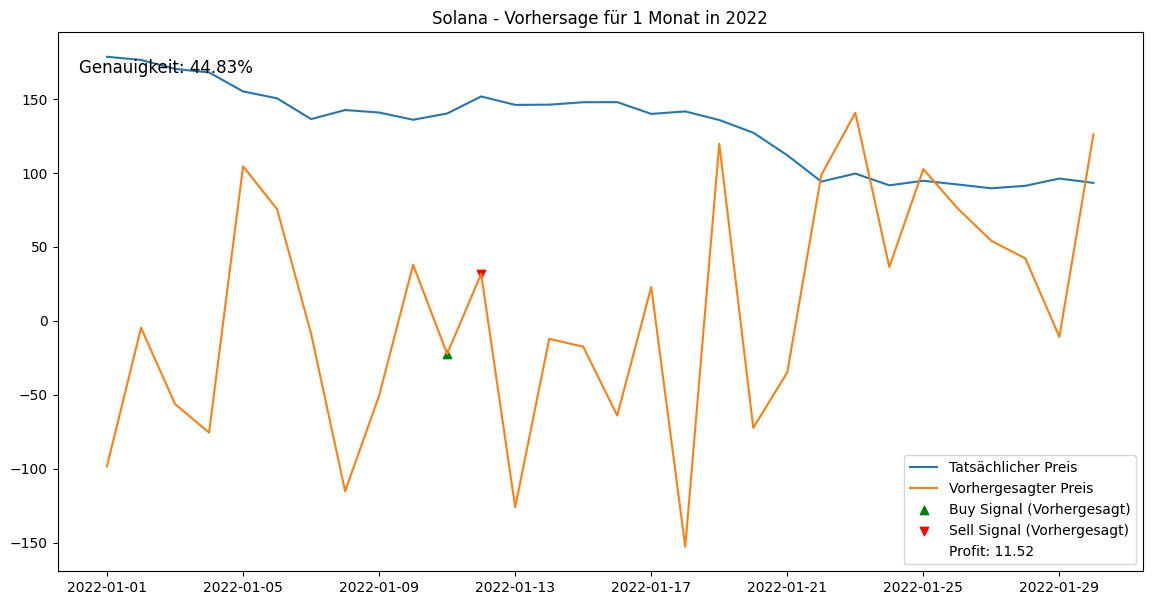

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import ta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import argrelextrema


# Datenabruf
def fetch_test_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date, progress=False)
    data.reset_index(inplace=True)
    return data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]


# Technische Indikatoren hinzufügen
def add_technical_indicators(df):
    df['rsi'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
    macd = ta.trend.MACD(close=df['Close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    bollinger = ta.volatility.BollingerBands(close=df['Close'])
    df['bb_mavg'] = bollinger.bollinger_mavg()
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    stochastic = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['stoch'] = stochastic.stoch()
    df['stoch_signal'] = stochastic.stoch_signal()
    df.fillna(0, inplace=True)
    return df


# Fehlende Spalten ergänzen
def add_missing_columns(df, required_columns):
    for col in required_columns:
        if col not in df.columns:
            df[col] = 0
    df = df[required_columns]
    return df


# Inverse Transformation der Vorhersagen
def inverse_transform(predictions, scaler, feature_columns):
    dummy = np.zeros((len(predictions), len(feature_columns)))
    close_index = feature_columns.index('Close')
    predictions = predictions.reshape(-1, 1)
    dummy[:, close_index] = predictions.flatten()
    inverted = scaler.inverse_transform(dummy)
    return inverted[:, close_index]


# Berechnung der Genauigkeit (Accuracy)
def calculate_accuracy(actual_prices, predicted_prices):
    correct_trend = 0
    total_predictions = len(actual_prices) - 1
    for i in range(1, len(actual_prices)):
        actual_trend = actual_prices[i] - actual_prices[i - 1]
        predicted_trend = predicted_prices[i] - predicted_prices[i - 1]
        if (actual_trend >= 0 and predicted_trend >= 0) or (actual_trend < 0 and predicted_trend < 0):
            correct_trend += 1
    accuracy = correct_trend / total_predictions
    return accuracy


# Buy- und Sell-Signale basierend auf den vorhergesagten Preisen
def find_best_single_trade(predicted_prices, actual_prices, date_values):
    buy_signals = argrelextrema(predicted_prices, np.less)[0]
    sell_signals = argrelextrema(predicted_prices, np.greater)[0]

    best_buy = None
    best_sell = None
    best_profit = -np.inf

    # Suche das beste Buy-Signal und das beste Sell-Signal basierend auf dem Profit
    for buy in buy_signals:
        for sell in sell_signals:
            if sell > buy:  # Sell muss nach Buy kommen
                profit = actual_prices[sell] - actual_prices[buy]  # Berechnung des Profits auf Grundlage der tatsächlichen Preise
                if profit > best_profit:
                    best_buy = buy
                    best_sell = sell
                    best_profit = profit

    return best_buy, best_sell, best_profit

# Modell evaluieren ohne rekursive Vorhersagen und mit Buy/Sell basierend auf den Vorhersagen
def evaluate_model(model_info, data, actual_data_2022, asset_name, prediction_steps=30):
    model = load_model(model_info["model_path"])
    with open(model_info["scaler_path"], 'rb') as f:
        scaler = pickle.load(f)
    feature_columns = model_info["feature_columns"]

    actual_dates_2022 = actual_data_2022['Date'].values
    actual_prices_2022 = actual_data_2022['Close'].values

    # Verwende nur Daten bis zum 31.12.2021 für die Vorhersage
    prediction_start_idx = len(data) - prediction_steps
    data = add_missing_columns(data, feature_columns)
    data = data[feature_columns]
    data_scaled = scaler.transform(data)

    # Nimm die letzten Daten als Eingabesequenz für das Modell (nur bis 2021)
    input_sequence = data_scaled[prediction_start_idx - 50:prediction_start_idx]

    # Vorhersage für 30 Schritte (1 Monat) basierend auf den Daten bis 2021
    predictions = model.predict(input_sequence[np.newaxis, :, :])
    predictions_inv = inverse_transform(predictions.flatten(), scaler, feature_columns)

    # Vergleiche die Vorhersagen mit den tatsächlichen Daten aus 2022
    prediction_steps = min(len(actual_dates_2022), len(predictions_inv), prediction_steps)

    # Berechnung der Genauigkeit mit RMSE und MAE
    rmse = np.sqrt(mean_squared_error(actual_prices_2022[:prediction_steps], predictions_inv[:prediction_steps]))
    mae = mean_absolute_error(actual_prices_2022[:prediction_steps], predictions_inv[:prediction_steps])
    accuracy = calculate_accuracy(actual_prices_2022[:prediction_steps], predictions_inv[:prediction_steps])

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Genauigkeit (Steigung/Senkung): {accuracy:.2%}")

    # Buy- und Sell-Signale basierend auf den Vorhersagen finden und tatsächlichen Profit berechnen
    buy_signal, sell_signal, profit = find_best_single_trade(predictions_inv[:prediction_steps],
                                                             actual_prices_2022[:prediction_steps],
                                                             actual_dates_2022[:prediction_steps])

    # Ausgabe der Vorhersagen und tatsächlichen Preise in eine CSV-Datei
    prediction_df = pd.DataFrame({
        'Datum': actual_dates_2022[:prediction_steps],
        'Tatsächlicher Preis': actual_prices_2022[:prediction_steps],
        'Vorhergesagter Preis': predictions_inv[:prediction_steps]
    })
    prediction_df.to_csv('sol_predictions.csv', index=False)
    print("Vorhersagen und tatsächliche Preise wurden in 'sol_predictions.csv' gespeichert.")

    # Plotten der Vorhersagen und tatsächlichen Preise
    plt.figure(figsize=(14, 7))
    plt.plot(actual_dates_2022[:prediction_steps], actual_prices_2022[:prediction_steps], label='Tatsächlicher Preis')
    plt.plot(actual_dates_2022[:prediction_steps], predictions_inv[:prediction_steps], label='Vorhergesagter Preis')

    # Buy- und Sell-Signale anzeigen
    if buy_signal is not None and sell_signal is not None:
        # Buy- und Sell-Signale basierend auf den vorhergesagten Preisen
        plt.scatter(actual_dates_2022[buy_signal], predictions_inv[buy_signal], marker='^', color='g',
                    label='Buy Signal (Vorhergesagt)')
        plt.scatter(actual_dates_2022[sell_signal], predictions_inv[sell_signal], marker='v', color='r',
                    label='Sell Signal (Vorhergesagt)')

        # Printen von Buy- und Sell-Daten
        print(
            f"Buy am {pd.to_datetime(actual_dates_2022[buy_signal]).date()} für {predictions_inv[buy_signal]:.2f} (Vorhergesagt) und Sell am {pd.to_datetime(actual_dates_2022[sell_signal]).date()} für {predictions_inv[sell_signal]:.2f} mit Profit von {profit:.2f}")

        # Füge den Profit als zusätzlichen Eintrag zur Legende hinzu
        plt.plot([], [], ' ', label=f'Profit: {profit:.2f}')

    # Genauigkeit im Diagramm anzeigen
    plt.text(0.02, 0.95, f"Genauigkeit: {accuracy:.2%}", transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top')

    plt.title(f'{asset_name} - Vorhersage für 1 Monat in 2022')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    # Lade Daten bis Ende 2021
    sol_data = fetch_test_data('SOL-USD', '2010-01-01', '2021-12-31')
    sol_data_with_indicators = add_technical_indicators(sol_data.copy())

    # Lade nur die Daten für 2022 zur Evaluierung (nicht für Vorhersage)
    sol_data_2022 = fetch_test_data('SOL-USD', '2022-01-01', '2022-01-31')
    sol_data_2022 = add_technical_indicators(sol_data_2022)

    model_info = {
        "model_path": "../../models/standard_model/sol_standard_model.h5",
        "scaler_path": "../../models/scaler/sol_scaler_with_indicators.pkl",
        "feature_columns": ['Open', 'High', 'Low', 'Close', 'Volume', 'Fed_Rate', 'Inflation', 'rsi', 'macd',
                            'macd_signal', 'bb_mavg', 'bb_high', 'bb_low', 'stoch', 'stoch_signal']
    }

    evaluate_model(model_info, sol_data_with_indicators, sol_data_2022, "Solana", prediction_steps=30)
